In [162]:
from easypip import easyimport, easyinstall, is_notebook
easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

[easypip] Installing bbrl_gymnasium>=0.2.0
[easypip] Installing bbrl_gymnasium[box2d]
[easypip] Installing bbrl_gymnasium[classic_control]


In [163]:
import os
import sys
from pathlib import Path
import math
import numpy as np

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime

from gymnasium import Env, Space, Wrapper, make

# Imports all the necessary classes and functions from BBRL
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, TemporalAgent

# ParallelGymAgent is an agent able to execute a batch of gymnasium environments
# with auto-resetting. These agents produce multiple variables in the workspace:
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/terminated’,
# 'env/truncated', 'env/done', ’env/cumulated_reward’, ... 
# 
# When called at timestep t=0, the environments are automatically reset. At
# timestep t>0, these agents will read the ’action’ variable in the workspace at
# time t − 1
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video

# Replay buffers are useful to store past transitions when training
from bbrl.utils.replay_buffer import ReplayBuffer

import torch.nn as nn

from typing import Tuple
from bbrl.agents.gymnasium import make_env, GymAgent, ParallelGymAgent
from functools import partial

from bbrl import instantiate_class

import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [164]:
# Utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

In [351]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 38 * 141, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [342]:
params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-buffer-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 4,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "n_updates": 32,
    "eval_interval": 2000,
    "learning_starts": 2000,
    "nb_evals": 10,
    "buffer_size": 1e6,
    "batch_size": 256,
    "target_critic_update": 5000,
    "max_epochs": 3500,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [64, 64]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 1e-3,
  }
}

config=OmegaConf.create(params)

In [355]:
from PIL import Image

def preProcess(im):
    plt.imshow(im)
    plt.show()
    img = Image.fromarray(im.astype(np.uint8))
    img_gray = img.convert('L')
    img_gray = img_gray.resize((564, 152)) #a modifier peut etre im.shape[1], im.shape[0])
    img_array = np.array(img_gray)

    return img_array

def crop(im):
    im = Image.fromarray(im.astype(np.uint8))
    width, height = im.size
 
    # Setting the points for cropped image
    new_width, new_height = 300, 300  # New dimensions for the crop
    left = (width - new_width)/8
    top = (height - new_height)/0.6
    right = (width + new_width)/1.5
    bottom = (height + new_height)/2.2
    
    # Cropped image of above dimension
    # (It will not change original image)
    im1 = im.crop((left, top, right, bottom))
    
    # Shows the image in image viewer
    img_array = np.array(im1)

    # Display the image
    return img_array


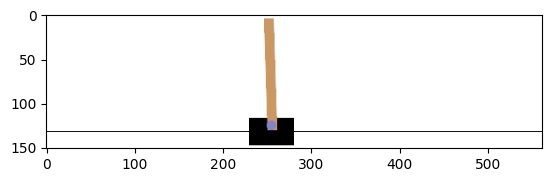

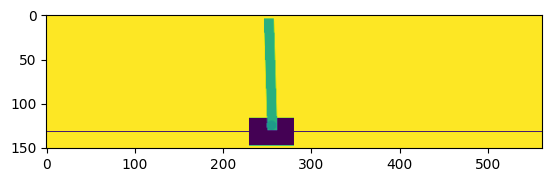

<class 'numpy.ndarray'>
Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
(151, 562)


In [356]:
env = make_env(config.gym_env.env_name, render_mode="rgb_array")
env.reset()
im = env.render()
im = crop(im)
im = preProcess(im)
plt.imshow(im)
plt.show()
print(type(im))
print(env.action_space)
print(env.observation_space)
print(im.shape)

In [357]:
model = Net()
img_tensor = torch.from_numpy(im).float()
img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # Resulting shape: [1, 1, 151, 562]

output = model(img_tensor)
print("Output shape:", output.shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x20720 and 196x10)